In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
import mplcyberpunk
import json
plt.style.use('cyberpunk')

### Perform Individual Student Analysis. 
#### Objectives: 
* Show progress over time
* Show improvement tips

#### To Do with senior batch data:
* Show most correlated senior
* Show tips to improve from best improved senior



In [3]:
ROLLNO = '2023IPM052'
T1 = ["LSE-IA","MIE-I","PHIL-I","DC","SM-I","SOC-I", "ITA"] #Dance/Drama not included because datesheet not found. 

#Meow meow load new idx
IDX = ["Name","Roll No.","Q1","Q2","MT","ET", "CP", "PROJ1", "PROJ2","Final",'GPA']
New_IDX = []
for i in IDX: New_IDX.append(i+'-Numeric')
New_IDX += IDX


In [4]:
#Load term1 data for dance/drama GPA since datasheet not included
term1 = pd.read_excel("Sheets\\Term1-Final-Computed.xlsx", sheet_name='RAW')
term1.fillna(0, inplace=True)
term1.set_index('Roll No.', inplace=True)
term1['Dance/Drama'] = term1['Dance -I'] + term1['Drama- I']
DD = term1['Dance/Drama']

In [5]:
# Load in new data
DATAS = {}

for course in T1:

    avail = []
    df = pd.read_excel('Sheets/Component-Wise Breakdown latest(AutoRecovered).xlsx', sheet_name=course)
    
    # Get available fields only (discard unnamed and other useless columns)
    for key in df.keys():
        if key in New_IDX: avail.append(key)

    df = df[avail] # Filter dataframe
    assert 'Roll No.' in avail, UserWarning('Roll number necessary')
    df.set_index('Roll No.', inplace=True)

    DATAS[course] = df
DATAS.keys()

dict_keys(['LSE-IA', 'MIE-I', 'PHIL-I', 'DC', 'SM-I', 'SOC-I', 'ITA'])

In [6]:
# print(DATAS['DC'].head())
Weights = {
    'DC': {
        'credits':6,
        'Q1':0.165, 'Q2': 0.165, 'MT':0.335, 'ET':0.335
    },
    'SOC-I': {
        'credits':4,
        'Q1':0.2, 'MT':0.4, 'PROJ1': 0.2, 'CP':0.2
    },
    'SM-I': {
        'credits':6,
        'Q1': 0.1, 'Q2':0.1, 'MT':0.3, 'ET': 0.5
    },
    'PHIL-I': {
        'credits':3,
        'ET':0.5, 'PROJ1':0.3, 'CP':0.2
    },
    'MIE-I': {
        'credits':4,
        'Q1':0.3, 'MT':0.3,'ET':0.3, 'CP':0.1
    },
    'ITA': {
        'credits':2,
        'ET':0.5, 'Q1':0.3, 'CP':0.2
    },
    'LSE-IA': {
        'credits':2,
        'ET':0.4, 'PROJ1':0.2, "PROJ2":0.2, 'CP':0.2
    }
}

dates = pd.read_excel('Sheets/Component-Wise Breakdown latest(AutoRecovered).xlsx', sheet_name='Dates')
dates.set_index('Dates', inplace=True)
dates

,Sub,Event
Dates,,
2023-09-13,MIE-I,Q1
2023-09-23,DC,Q1
2023-09-25,SM-I,Q1
2023-09-30,MIE-I,MT
2023-10-05,ITA,Q1
2023-10-19,DC,MT
2023-10-20,SM-I,MT
2023-10-21,SOC-I,MT
2023-10-22,ITA,ET


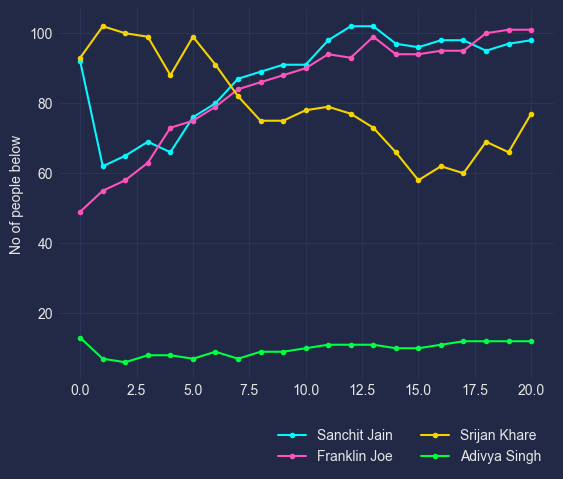

In [7]:
def generate_starting_score(rollnos: list, include_only_CP=False, exclude_list=[]):
    """
    Generates a new series containing tentative scores that calculates CP & Dance/Drama scores only. 

    rollnos: list of roll numbers to generate the series for.
    exclude_dd: if True, it does not weigh in Dance / Drama scores as 
    """
    start_series = pd.Series(index=rollnos)
    for rollno in rollnos:
        start_score = 0
        for sub in Weights.keys():
            if 'CP' in Weights[sub].keys() and (sub not in exclude_list):
                # print(f'Adding {sub} CP score')
                start_score += Weights[sub]['CP'] * Weights[sub]['credits'] * DATAS[sub]['CP-Numeric'][rollno]
        if not include_only_CP: start_score += DD[rollno] * (13/4.33) * 4  # Scale the GPA score to match with the grade 13 scores and multiply with weight
        start_series[rollno] = start_score
        
    return start_series

def _add_new_score(old_scores: pd.Series, event_date):
    """
    INTERNAL FUNCTION: USED BY generate_rank_list
    Takes in a series and creates new tentative score by adding the weighted component scores.

    old_scores: series containing old tentative scores.
    event_date: date at which the event takes place.
    """
    if event_date in dates.index:

        sub = dates['Sub'][event_date]; event = dates['Event'][event_date]
        new_scores = pd.Series(index=old_scores.index).fillna(0) #Create new series with same index as old one. 
        for rollno in old_scores.index:
            # print(DATAS[sub][event+'-Numeric'][rollno])
            new_scores[rollno] =  old_scores[rollno] + (Weights[sub]['credits'] * Weights[sub][event] * DATAS[sub][event+'-Numeric'][rollno])

    return new_scores

def generate_rank_list(start_series, rollno,include_free_time=True, include_date_index=True):
    """
    Generates a list of ranks that the target participant has held over time in order.
    =========================================================================================
    start_series: pd.Series -> that contains the starting tentative scores (generated by generate_starting_score)

    rollno      : str -> roll number of participant who's ranks have to be calculated

    dates       : pd.DataFrame object -> with index as date index and two columns: 'Sub' and 'Event'. 

    include_free_time: bool -> whether to give ranks data for every single day between term start & end or just the days where ranks changed

    include_date_index: bool -> whether to set the index of returned Series as the dates. This will affect the scaling when plotted as dates will provide a more accurate scaling.
    =========================================================================================
    Returns: pandas Series object (columns are dates)

    """
    last_event = start_series  # Set last event object so that it the new score can be added on top of this. 

    # Initialize date sequences based on if user wants all dates or just dates with exam events.
    if include_free_time:  # If user wants all dates
        startdate = '2023-09-01'; end_date=dates.index[len(dates)-1]
        datesequence = pd.date_range(start=startdate, end=end_date)

    else: datesequence = dates.index  # If just exam dates. 
    

    ranks = pd.Series(index=datesequence)  #Initialize series that holds the ranks (to be returned)

    ranks[datesequence[0]] = (159 - start_series.rank(ascending=False)[rollno]) # Input the starting rank (computed by generate_starting_score func)

    #Main loop where each rank is calculated for each date and appended. 
    for eventdate in datesequence:
        if eventdate in dates.index:  # This will always be True if datesequence only contains exam event dates.
            new_event = _add_new_score(last_event, eventdate)
            ranks[eventdate] = (159 - new_event.rank(ascending=False)[rollno])
            last_event = new_event
        else:
            ranks[eventdate] = list(ranks.dropna())[-1]  # Add the last element in this 

    if not include_date_index: ranks.reset_index(inplace=True, drop=True)
    return ranks


# Test generation 

start = generate_starting_score(rollnos=DATAS['DC'].index)

def multi_plot(rollnos: list):
    start = generate_starting_score(rollnos=DATAS['DC'].index)
    for rollno in rollnos:
        plt.plot(generate_rank_list(start, rollno, False, False), label=DATAS['DC']['Name'][rollno].title(),
                  marker='.')
    
    plt.legend(bbox_to_anchor=(1, -0.1), ncol=2)
    plt.ylabel('No of people below')
        

multi_plot(rollnos=[ '2023IPM106', '2023IPM052', '2023IPM125', '2023IPM014'])

In [8]:
#Correlation analysis:
# We try to find students with similar academic profile by analyzing correlation between rank lists

target = '2023IPM052'

#get target's ranklist 
t_ranklist = generate_rank_list(start, target, False, False) # in np array for corr calculation

correlations = pd.Series(index=DATAS['DC'].index)

for rollno in DATAS['DC'].index:
    correlations[rollno] = t_ranklist.corr(generate_rank_list(start, rollno, False, False))

correlations
    

Roll No.
2022IPM084   -0.542104
2022IPM157   -0.448903
2023IPM002    0.640433
2023IPM003    0.423964
2023IPM005   -0.915844
                ...   
2023IPM161    0.939705
2023IPM162   -0.801336
2023IPM164    0.935543
2023IPM166   -0.948481
2023IPM167    0.935445
Length: 159, dtype: float64

In [14]:
ranked = correlations.rank(ascending=False).sort_values().head(10)
worst  = correlations.rank(ascending=False).sort_values().tail(10)

print(f'Students with similar academic profile to {DATAS["DC"]["Name"][target]}:')
print('---------------------------------------------------------------------------')
total_corr_score = 0
for i in range(len(ranked.index)):
    if i == 0: continue
    total_corr_score += correlations[ranked.index[i]]
    print(f'{i}. [{round(correlations[ranked.index[i]],3)}] {DATAS["DC"]["Name"][ranked.index[i]]} - {ranked.index[i]}')
print('---------------------------------------------------------------------------')
print(f'AVG CORRELATION SCORE = {round(total_corr_score/9, 3)}')  #WARN -> const to be changed before reuse
print('---------------------------------------------------------------------------')

# Now Display most different students. 
for i in range(len(worst.index)):
    if i == 0: continue
    print(f'{i}. [{round(correlations[worst.index[i]],3)}] {DATAS["DC"]["Name"][worst.index[i]]} - {worst.index[i]}')

Students with similar academic profile to FRANKLIN JOE:
---------------------------------------------------------------------------
1. [0.97] VATSAL JAIN - 2023IPM145
2. [0.964] TARUN K - 2023IPM135
3. [0.963] SHANTANU CHHAPARIA - 2023IPM112
4. [0.958] TANMAY KESHRI - 2023IPM134
5. [0.955] SREEHARI S - 2023IPM124
6. [0.955] ANANT JAIN - 2023IPM020
7. [0.952] PILLARISETTY GEETIKA SAI - 2023IPM088
8. [0.949] ANANYA BORO - 2023IPM022
9. [0.949] SNEHASHWETA PRADHAN - 2023IPM120
---------------------------------------------------------------------------
AVG CORRELATION SCORE = 0.957
---------------------------------------------------------------------------
1. [-0.948] ROHAN RAJ - 2023IPM166
2. [-0.95] NANDANA B. - 2023IPM081
3. [-0.954] TANISHA BHATTACHARYA - 2023IPM131
4. [-0.96] TARAK SHARMA - 2023IPM155
5. [-0.961] RISHI SISODIYA - 2023IPM099
6. [-0.965] SWETA RAMVEER SINGH - 2023IPM129
7. [-0.967] SAHAJ CHOUDHARY - 2023IPM154
8. [-0.967] SOUMYAJIT MONDAL - 2023IPM123
9. [-0.974] AGREEM

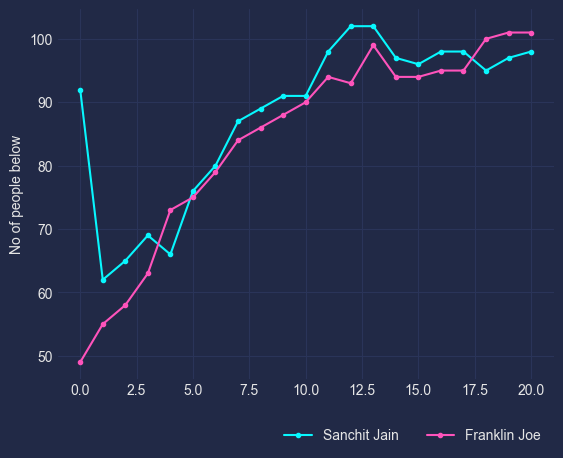

In [24]:
multi_plot(['2023IPM106', '2023IPM052'])

In [28]:
"""
CP Index:
CP Index ranks participants based on their performance in CPs. 
"""

CP_scores = generate_starting_score(include_only_CP=True, rollnos=DATAS['DC'].index).rank(ascending=False)
CP_scores['2023IPM052']

38.5